In [52]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

import sys
sys.path.append('..')

This notebook is a guide for the reconstruction analysis of the library of the project "". :)

Météo-France, CNRS, CNRM, Centre d’Etudes de la Neige \
Léo Catteau, Spring 2025

### Contents:
* [Spatial aggregation of error](#first-subbullet)
* [Temporal aggregation of error](#second-subbullet)
* [Weather bench](#third-subbullet)

In [53]:
from data_provider.data_provider import DataProvider
from models.linear import linear
from trainer.Filler import Filler

from types import SimpleNamespace

In [54]:
data_kwargs = SimpleNamespace()
data_kwargs.data = 'bdclim_clean'
data_kwargs.dataset = 'WindowHorizonDataset'
data_kwargs.root_path = '../../datasets/'
data_kwargs.data_path = 'bdclim_safran_2023-2024.nc'
data_kwargs.has_predictors = False
data_kwargs.scaler = None
data_kwargs.batch_size = 50
data_kwargs.mask_length = 24*7*10
data_kwargs.mask_proba = 0.5
data_kwargs.window = 24
data_kwargs.horizon = 0

data_provider = DataProvider(data_kwargs)
clean_data = data_provider.dataset.data
corrupted_data = data_provider.dataset.corrupted_data
mask = data_provider.dataset.mask

model_kwargs = dict(seq_dim=data_provider.data.n_nodes)
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-4
filler_kwargs.epochs = 100
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba

filler = Filler(linear, model_kwargs, filler_kwargs)
filler.load_model('../trained_models/linear.pt')

device:  cpu
device:  cpu


/Users/leocatteau/Desktop/EPFL/Météo-France/code/Meteo-France/notebook_guides/../data_provider/data_preparation.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data)


In [55]:
reconstructed_data = filler.reconstruct(corrupted_data, mask)

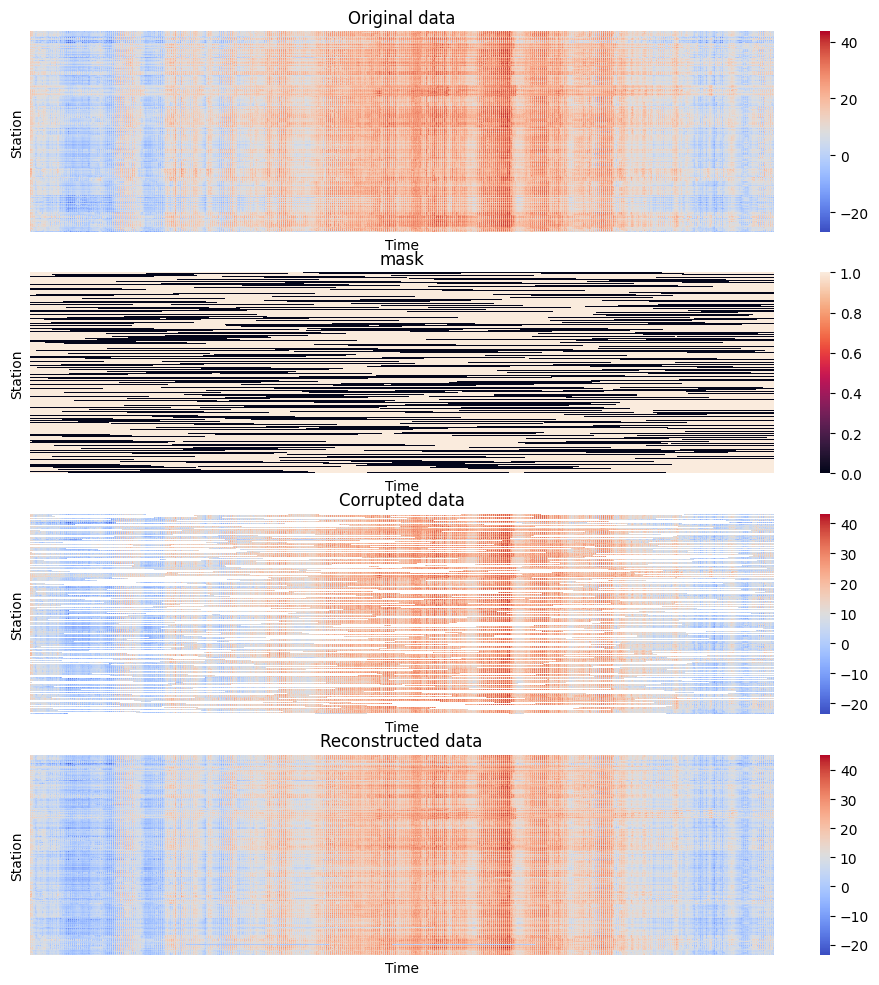

In [56]:
fig, ax = plt.subplots(4, 1, figsize=(12, 12))
sns.heatmap(clean_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Original data")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Station")
sns.heatmap(mask.T, xticklabels=False, yticklabels=False, ax=ax[1])
ax[1].set_title("mask")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Station")
sns.heatmap(corrupted_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[2])
ax[2].set_title("Corrupted data")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Station")
sns.heatmap(reconstructed_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[3])
ax[3].set_title("Reconstructed data")
ax[3].set_xlabel("Time")
ax[3].set_ylabel("Station")
plt.show()

### Spatial aggregation of error <a class="anchor" id="first-bullet"></a>

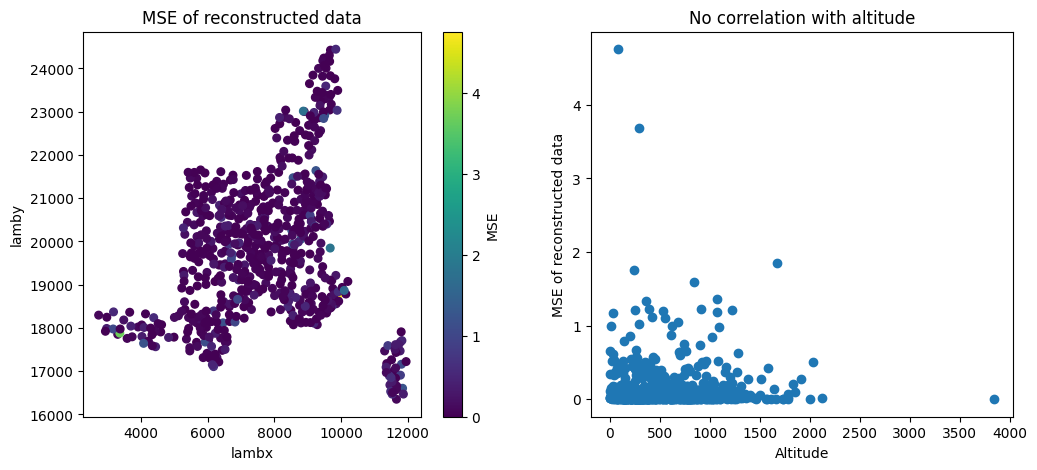

In [60]:
spatial_MSE = torch.square(torch.mean(reconstructed_data - clean_data, dim=0))
coords = [data_provider.data.predictors['lambx'].values, data_provider.data.predictors['lamby'].values]
altitude = data_provider.data.predictors['ZS'].values

treshold = 9
loc_aberrations = np.where(spatial_MSE > treshold)
spatial_MSE = spatial_MSE[np.where(spatial_MSE<treshold)]
coords = [coords[0][np.where(spatial_MSE<treshold)], coords[1][np.where(spatial_MSE<treshold)]]
altitude = altitude[np.where(spatial_MSE<treshold)]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(coords[0], coords[1], c=spatial_MSE, cmap='viridis', s=30)
plt.colorbar(ax[0].collections[0], ax=ax[0], label='MSE')
ax[0].set_title('MSE of reconstructed data')
ax[0].set_xlabel('lambx')
ax[0].set_ylabel('lamby')
ax[1].scatter(altitude, spatial_MSE)
ax[1].set_xlabel('Altitude')
ax[1].set_ylabel('MSE of reconstructed data')
ax[1].set_title('No correlation with altitude')
plt.show()

### Temporal aggregation of error <a class="anchor" id="second-bullet"></a>